# Logistic Regression with amplpy
[![logistic_regression.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/amplcolab/blob/master/authors/glebbelov/conic/logistic_regression.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/amplcolab/blob/master/authors/glebbelov/conic/logistic_regression.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/amplcolab/blob/master/authors/glebbelov/conic/logistic_regression.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/amplcolab/blob/master/authors/glebbelov/conic/logistic_regression.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/amplcolab/blob/master/authors/glebbelov/conic/logistic_regression.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/amplcolab/blob/master/authors/glebbelov/conic/logistic_regression.ipynb)](https://colab.ampl.com)

Description: Logistic regression with amplpy using exponential cones

Tags: highlights, amplpy, regression, sigmoid, softplus, log-sum-exp, classifier, regularization, machine learning, conic, exponential cone, second-order cone, quadratic cone, formulation comparison

Notebook author: Gleb Belov <<gleb@ampl.com>>, Filipe Brandão <<fdabrandao@gmail.com>>

References:
1. Small data set example:
   - https://docs.mosek.com/modeling-cookbook/expo.html#logistic-regression,
   - https://docs.mosek.com/latest/pythonapi/case-studies-logistic.html#.
2. Large data set:
   - Lohweg, Volker. (2013). banknote authentication. UCI Machine Learning Repository. https://doi.org/10.24432/C55P57.
3. amplpy documentation: https://amplpy.readthedocs.io/.


In [1]:
# Install dependencies
!pip install -q amplpy pandas numpy matplotlib

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, tools
ampl = tools.ampl_notebook(
    modules=["coin", "mosek"], # modules to install
    license_uuid="default") # license to use

In [3]:
FILTER_DATA_FOR_MOSEK = True # Set this to False if you activated a license with full access to MOSEK.
# With the demo license, MOSEK only accepts models under 500 variables and constraints.

# Modeling in AMPL

## Formulation as a convex optimization problem

Define the logistic function

$$S(x)=\frac{1}{1+e^{-x}}.$$

Next, given an observation $x\in\mathbf{R}^d$ and weights $\theta\in\mathbf{R}^d$ we set

$$ h_\theta(x)=S(\theta^Tx)=\frac{1}{1+e^{-\theta^Tx}}.$$

The weights vector $\theta$ is part of the setup of the classifier. The expression
$h_\theta(x)$ is interpreted as the probability that $x$ belongs to class 1.
When asked to classify $x$ the returned answer is

$$ \begin{split}x\mapsto \begin{cases}\begin{array}{ll}1, & h_\theta(x)\geq 1/2, \\ 0, & h_\theta(x) < 1/2.\end{array}\end{cases}\end{split}$$

When training a logistic regression algorithm we are given a sequence of training examples $x_i$, each labelled with its class $y_i\in \{0,1\}$ and we seek to find the weights
$\theta$ which maximize the likelihood function $\textstyle \prod_i h_\theta(x_i)^{y_i}(1-h_\theta(x_i))^{1-y_i}$.
Of course every single $y_i$ equals 0 or 1, so just one factor appears in the product for each training data point:

$$ \max_\theta \textstyle \prod_{i:y_i=1} h_\theta(x_i) \prod_{i:y_i=0} (1-h_\theta(x_i).$$

By taking logarithms we obtain a sum that is easier to optimize:

$$ \max_\theta \sum_{i:y_i=1} \log(h_\theta(x_i))+\sum_{i:y_i=0}\log(1-h_\theta(x_i)). $$

Note that by negating we obtain the logarithmic loss function:

$$ J(\theta) = -\sum_{i:y_i=1} \log(h_\theta(x_i))-\sum_{i:y_i=0}\log(1-h_\theta(x_i)). $$

The training problem with regularization (a standard technique to prevent overfitting) is now equivalent to

$$ \min_\theta J(\theta) + \lambda\|\theta\|_2. $$


This formulation can be solved with a general nonlinear solver, such as Ipopt.

In [4]:
%%writefile logistic_regression.mod

set POINTS;
set DIMS;                  # Dimensionality of x

param y{POINTS} binary;    # Points' classes
param x{POINTS, DIMS};
param lambd;               # Regularization parameter

var theta{DIMS};           # Regression parameter vector
var hTheta{i in POINTS}
    = 1 / (1 + exp( - sum{d in DIMS} theta[d]*x[i, d] ));

minimize Logit:            # General nonlinear formulation
    - sum {i in POINTS: y[i] >0.5} log( hTheta[i] )
    - sum {i in POINTS: y[i]<=0.5} log( 1.0 - hTheta[i] )
    + lambd * sqrt( sum {d in DIMS} theta[d]^2 );

Overwriting logistic_regression.mod


## Formulation as a conic program

For a conic solver such as Mosek, we need to reformulate the problem.

The objective function can equivalently be phrased as

$$
\begin{split}\begin{array}{lrllr}
\min & \sum_i t_i +\lambda r  \\
\text{s.t.} & t_i      & \geq - \log(h_\theta(x))   & = \log(1+e^{-\theta^Tx_i}) & \mathrm{if}\ y_i=1, \\
         & t_i      & \geq - \log(1-h_\theta(x)) & = \log(1+e^{\theta^Tx_i})  & \mathrm{if}\ y_i=0, \\
         & r        & \geq \|\theta\|_2.
\end{array}\end{split}
$$

The key point is to implement the [softplus bound](https://docs.mosek.com/modeling-cookbook/expo.html#softplus-function) $t\geq \log(1+e^u)$, which is the simplest example of a log-sum-exp constraint for two terms. Here $t$ is a scalar variable and $u$ will be the affine expression of the form $\pm \theta^Tx_i$. This is equivalent to

$$
e^{u-t} + e^{-t} \leq 1
$$

and further to

$$
\begin{split}\begin{array}{rclr}
z_1  & \ge  & e^{u-t}, \\
z_2  & \ge  & e^{-t}, \\
z_1+z_2       & \leq & 1.
\end{array}\end{split}
$$


In [5]:
%%writefile logistic_regression_conic.mod

set POINTS;
set DIMS;                  # Dimensionality of x

param y{POINTS} binary;    # Points' classes
param x{POINTS, DIMS};
param lambd;               # Regularization parameter

var theta{DIMS};           # Regression parameter vector
var t{POINTS};
var u{POINTS};
var v{POINTS};
var r >= 0;

minimize LogitConic:
    sum {i in POINTS} t[i] + lambd * r;

s.t. Softplus1{i in POINTS}:  # reformulation of softplus
    u[i] + v[i] <= 1;
s.t. Softplus2{i in POINTS}:
    u[i] >= exp(
        (if y[i]>0.5 then     # y[i]==1
            -sum {d in DIMS} theta[d] * x[i, d]
         else
            sum {d in DIMS} theta[d] * x[i, d]
        ) - t[i]
    );
s.t. Softplus3{i in POINTS}:
    v[i] >= exp(-t[i]);

s.t. Norm_Theta:              # Quadratic cone for regularizer
    r^2 >= sum {d in DIMS} theta[d]^2;


Overwriting logistic_regression_conic.mod


## Load data directly from Python data structures using [amplpy](https://amplpy.readthedocs.io/)

In [6]:
import time

def logistic_regression(label, data, lambd, modfile, solver):
    # Create AMPL instance and load the model
    ampl = AMPL()
    ampl.read(modfile)

    # load the data
    ampl.set["POINTS"] = data.index
    ampl.set["DIMS"] = data.columns
    ampl.param["y"] = label
    ampl.param["x"] = data
    ampl.param["lambd"] = lambd

    # solve
    ampl.option["solver"] = solver  # mosek, ipopt, knitro
    ampl.eval("let{d in DIMS} theta[d] := 0.0001;") # initial guesses for IPOPT
    tm = time.perf_counter()
    solve_output = ampl.get_output("solve;")
    tm = time.perf_counter() - tm

    solve_result = ampl.get_value("solve_result")
    solve_message = ampl.get_value("solve_message")
    print(solve_message.strip())
    if solve_result != "solved":
        print(f"Warning: solve_result = {solve_result}")
        # print(solve_output.strip())

    # return solution and solve time
    return ampl.get_variable("theta").to_pandas(), tm

# 1. Initial example with a small data set

In the first part, we will implement regularized logistic regression to predict whether microchips from a fabrication plant pass quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected.

## Load example data into Pandas DataFrame

We start by partitioning the data into separate training and test sets to assess the model's performance on unseen data.


In [7]:
# function to split a dataset into train/test datasets
def split_df(df, demo_limits=False):
    sample_size = int(df.shape[0]*0.70)
    if demo_limits:  # adjust sample size to work under demo limit for MOSEK
        sample_size = min(sample_size, int((500-28)/7))
    train_df = df.sample(n=sample_size, random_state=123)
    test_df = df.drop(train_df.index)
    return train_df, test_df

In [8]:
import pandas as pd
import numpy as np
df = pd.read_csv(
    "https://raw.githubusercontent.com/ampl/amplcolab/master/datasets/regression/logistic_regression_ex2data2.csv",
    header=None,
    names = ["Test1", "Test2", "Label"]
)
train_df, test_df = split_df(df, demo_limits=FILTER_DATA_FOR_MOSEK)
display(train_df.T)

,4,90,56,85,28,117,63,87,94,33,...,54,11,88,65,14,6,16,26,81,30
Test1,-0.51325,-0.50749,-0.219470,-0.697580,-0.13882,0.632650,0.60426,-0.69758,-0.10426,-0.28283,...,-0.20795,0.52938,-0.40380,0.92684,0.54666,-0.398040,0.16647,0.46601,-0.13306,-0.26555
Test2,0.46564,0.90424,-0.016813,0.041667,0.54605,-0.030612,0.59722,0.68494,0.99196,0.47295,...,0.17325,-0.52120,0.70687,0.36330,0.48757,0.034357,0.53874,-0.53582,-0.44810,0.96272
Label,1.00000,0.00000,1.000000,0.000000,1.00000,0.000000,0.00000,0.00000,0.00000,1.00000,...,1.00000,1.00000,0.00000,0.00000,1.00000,1.000000,1.00000,1.00000,0.00000,1.00000


## Visualize data

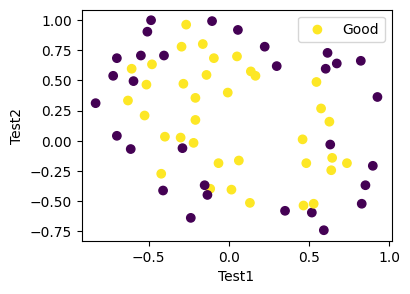

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(x=train_df["Test1"], y=train_df["Test2"], c=train_df["Label"], label="Good")
ax.set_xlabel("Test1")
ax.set_ylabel("Test2")
ax.legend()
plt.show()

## Lift the 2D data

Logistic regression is an example of a binary classifier, where the output takes one of the two values 0 or 1 for each data point. We call the two values *classes*.

As we see from the plot, a linear separation of the classes is not reasonable. We lift the 2D data into $\mathbf{R}^{28}$ via sums of monomials of degrees up to 6.


In [10]:
def safe_pow(x, p):
    if np.min(x) > 0 or p.is_integer():
        return x**p
    x1 = np.array(x)
    x2 = np.array(x)
    x1[x1 < 0] = -(-x1[x1 < 0])**p
    x2[x2 > 0] = x2[x2 > 0]**p
    x2[x < 0] = x1[x < 0]
    return x2

def lift_to_degree(x, y, deg, step=1):
    result = pd.DataFrame()
    for i in np.arange(0, deg+step, step):
        for j in np.arange(0, i+step, step):
            temp = safe_pow(x, i) + safe_pow(y, (i-j))
            result[f"V{i}{i-j}"] = temp
    return result

In [11]:
degree_lift = 6
degree_step = 1
train_df_lifted = lift_to_degree(train_df["Test1"], train_df["Test2"], degree_lift, degree_step)
test_df_lifted = lift_to_degree(test_df["Test1"], test_df["Test2"], degree_lift, degree_step)
display(train_df_lifted)

,V00,V11,V10,V22,V21,V20,V33,V32,V31,V30,...,V52,V51,V50,V66,V65,V64,V63,V62,V61,V60
4,2.0,-0.047610,0.48675,0.480246,0.729066,1.263426,-0.034243,0.081617,0.330437,0.864797,...,0.181205,0.430024,0.964384,0.028473,0.040170,0.065291,0.119240,0.235101,0.483920,1.018280
90,2.0,0.396750,0.49251,1.075196,1.161786,1.257546,0.608650,0.686948,0.773538,0.869298,...,0.783988,0.870578,0.966338,0.563724,0.621614,0.685635,0.756435,0.834733,0.921323,1.017083
56,2.0,-0.236283,0.78053,0.048450,0.031354,1.048167,-0.010576,-0.010289,-0.027384,0.989429,...,-0.000227,-0.017322,0.999491,0.000112,0.000112,0.000112,0.000107,0.000394,-0.016701,1.000112
85,2.0,-0.655913,0.30242,0.488354,0.528285,1.486618,-0.339383,-0.337719,-0.297788,0.660545,...,-0.163449,-0.123518,0.834815,0.115230,0.115230,0.115233,0.115302,0.116966,0.156897,1.115230
28,2.0,0.407230,0.86118,0.317442,0.565321,1.019271,0.160141,0.295495,0.543375,0.997325,...,0.298119,0.545998,0.999948,0.026516,0.048554,0.088913,0.162823,0.298178,0.546057,1.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,2.0,-0.363683,0.60196,0.159616,0.192793,1.158436,-0.063023,-0.061883,-0.028707,0.936936,...,-0.008811,0.024365,0.990008,0.003977,0.003977,0.003978,0.004018,0.005157,0.038334,1.003977
16,2.0,0.705210,1.16647,0.317953,0.566452,1.027712,0.160978,0.294854,0.543353,1.004613,...,0.290369,0.538868,1.000128,0.024471,0.045405,0.084261,0.156386,0.290262,0.538761,1.000021
26,2.0,-0.069810,1.46601,0.504268,-0.318655,1.217165,-0.052634,0.388304,-0.434619,1.101201,...,0.309080,-0.513843,1.021977,0.033907,-0.033925,0.092670,-0.143594,0.297345,-0.525578,1.010242
81,2.0,-0.581160,0.86694,0.218499,-0.430395,1.017705,-0.092331,0.198438,-0.450456,0.997644,...,0.200752,-0.448142,0.999958,0.008101,-0.018061,0.040324,-0.089970,0.200799,-0.448094,1.000006


## Solve and visualize

In [12]:
def plot_regression(qa, lambd, theta, ax):
    x, y, c = qa["Test1"], qa["Test2"], qa["Label"]
    ax.scatter(x, y, c=c, label="Good", alpha=0.3)
    x0, y0, x1, y1 = min(x), min(y), max(x), max(y)
    xd = (x1-x0)/10
    yd = (y1-y0)/10
    xr = np.linspace(x0-xd, x1+xd, 500)
    yr = np.linspace(y0-xd, y1+xd, 500)
    X, Y = np.meshgrid(xr, yr)                # grid of points
    X1 = np.reshape(X, (500*500))
    Y1 = np.reshape(Y, (500*500))
    X1Y1lft = lift_to_degree(X1, Y1, degree_lift, degree_step)
    theta_by_X1Y1 = theta.T @ X1Y1lft.T
    # Fails on Colab with Python 3.10:
    # theta_by_XY = np.reshape(theta_by_X1Y1, (500, 500))
    Z = np.zeros_like(X)
    for i in range(500):
        for j in range(500):
            Z[i,j] = 1 if -theta_by_X1Y1.iloc[0, i*500 + j] > 0 else 0
    cp = ax.contour(X, Y, Z)
    ax.set_title(f"lambda = {lambd}")

In [13]:
def solve_and_subplot(train_df, train_df_lifted, lambd, ax, mdl, slv):
    theta, tm = logistic_regression(train_df["Label"], train_df_lifted, lambd, mdl, slv)
    print(f"Solving time: {tm:.2f} sec.")
    #display(theta.T)
    plot_regression(train_df, lambd, theta, ax)
    return theta, tm

In [14]:
def benchmark_lambda(train_df, train_df_lifted, modfile, solver):
    fig, ax = plt.subplots(2, 2, figsize=(9, 7))
    theta = {}
    theta[0], _ =  solve_and_subplot(train_df, train_df_lifted, 0, ax[0, 0], modfile, solver)
    theta[0.1], _ = solve_and_subplot(train_df, train_df_lifted, 0.1, ax[0, 1], modfile, solver)
    theta[1], _ = solve_and_subplot(train_df, train_df_lifted, 1, ax[1, 0], modfile, solver)
    theta[10], _ = solve_and_subplot(train_df, train_df_lifted, 10, ax[1, 1], modfile, solver)
    plt.show()
    return theta

Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.04 sec.
Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.04 sec.
Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.03 sec.
Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.12 sec.


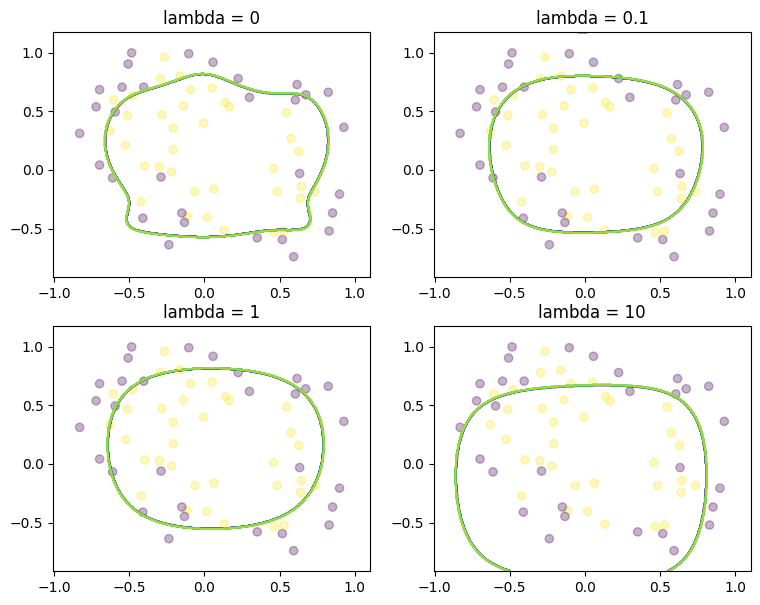

In [15]:
theta_logistic_ipopt = benchmark_lambda(train_df, train_df_lifted, "logistic_regression.mod", "ipopt")

Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.37 sec.
Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.23 sec.
Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.20 sec.
Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.28 sec.


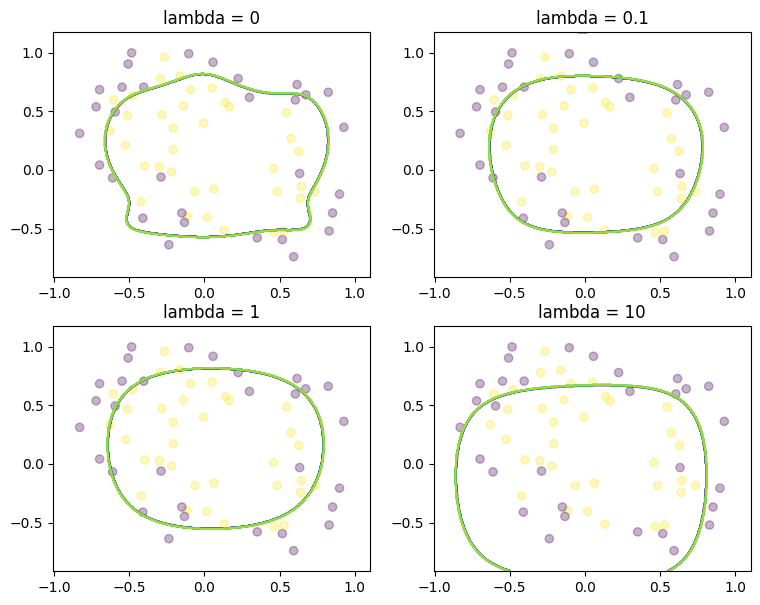

In [16]:
theta_conic_ipopt = benchmark_lambda(train_df, train_df_lifted, "logistic_regression_conic.mod", "ipopt")

MOSEK 10.0.43: optimal; objective 28.81852891
0 simplex iterations
12 barrier iterations
Solving time: 0.07 sec.
MOSEK 10.0.43: optimal; objective 30.90498809
0 simplex iterations
9 barrier iterations
Solving time: 0.04 sec.
MOSEK 10.0.43: optimal; objective 35.10091469
0 simplex iterations
10 barrier iterations
Solving time: 0.06 sec.
MOSEK 10.0.43: optimal; objective 46.19055461
0 simplex iterations
12 barrier iterations
Solving time: 0.04 sec.


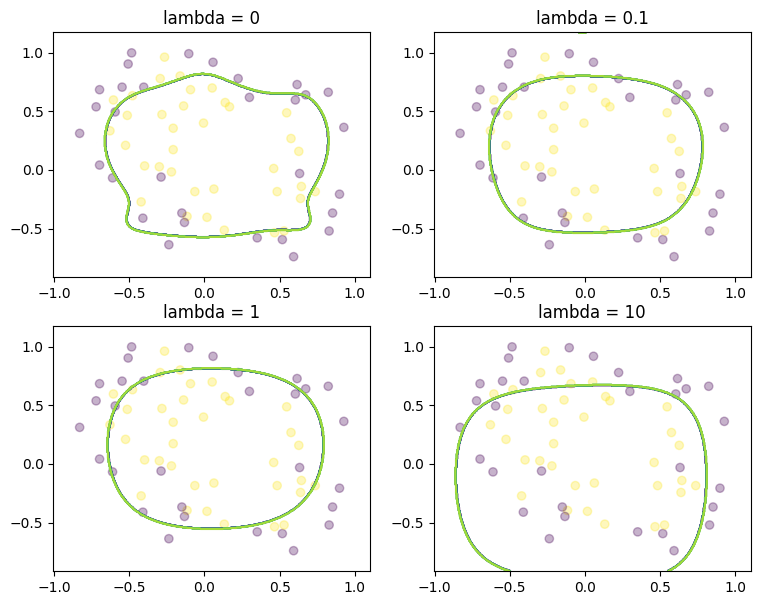

In [17]:
theta_conic_mosek = benchmark_lambda(train_df, train_df_lifted, "logistic_regression_conic.mod", "mosek")

## Evaluate perfornace the optimal $\theta$ for each lambda on the test set



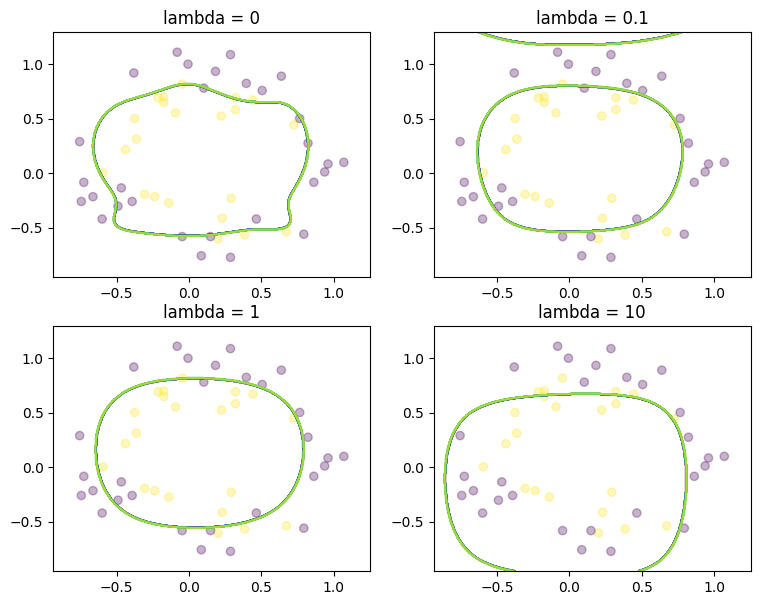

In [18]:
theta = theta_conic_mosek  # using theta from the conic model with MOSEK
fig, axes = plt.subplots(2, 2, figsize=(9, 7))
for lambd, axis in zip([0, 0.1, 1, 10], np.ravel(axes).tolist()):
    plot_regression(test_df, lambd, theta[lambd], axis)
plt.show()

In [19]:
# Check the accuracy for each lambda
for lambd in [0, 0.1, 1, 10]:
    result_df = test_df.copy()
    result_df["pred"] = test_df_lifted.dot(theta[lambd]) >= 0
    accuracy = sum(result_df["Label"] == result_df["pred"])/len(result_df)
    print(f"accuracy with lambda={lambd:5.2f}: {accuracy*100:.2f}%")

accuracy with lambda= 0.00: 74.51%
accuracy with lambda= 0.10: 82.35%
accuracy with lambda= 1.00: 82.35%
accuracy with lambda=10.00: 62.75%


## Discussion

Logistic regression can be modeled as a convex nonlinear optimization problem.

We considered an example with none, medium and strong regularization (small, medium, large lambda). Without regularization we get obvious overfitting.

# 2. A larger data set

We consider a larger data set from [2], explored in Chapter 6 of the book [Mathematical Optimization with AMPL in Python](https://mo-book-with-ampl.readthedocs.io/). The following data set contains data from a collection of known genuine and known counterfeit banknote specimens. The data includes four continuous statistical measures obtained from the wavelet transform of banknote images named “variance”, “skewness”, “curtosis”, and “entropy”, and a binary variable named “class” which is 0 if genuine and 1 if counterfeit.

In [20]:
# read data set
df = pd.read_csv(
    "https://raw.githubusercontent.com/ampl/amplcolab/master/datasets/regression/data_banknote_authentication.csv",
    header=None,
)
df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]
df.name = "Banknotes"
display(df.T)    # Transposed

,0,1,2,3,4,5,6,7,8,9,...,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371
variance,3.62160,4.5459,3.86600,3.4566,0.32924,4.3684,3.59120,2.09220,3.20320,1.53560,...,-2.166800,-1.16670,-2.83910,-4.50460,-2.41000,0.40614,-1.38870,-3.7503,-3.5637,-2.54190
skewness,8.66610,8.1674,-2.63830,9.5228,-4.45520,9.6718,3.01290,-6.81000,5.75880,9.17720,...,1.593300,-1.42370,-6.63000,-5.81260,3.74330,1.34920,-4.87730,-13.4586,-8.3827,-0.65804
curtosis,-2.80730,-2.4586,1.92420,-4.0112,4.57180,-3.9606,0.72888,8.46360,-0.75345,-2.27180,...,0.045122,2.92410,10.48490,10.88670,-0.40215,-1.45010,6.47740,17.5932,12.3930,2.68420
entropy,-0.44699,-1.4621,0.10645,-3.5944,-0.98880,-3.1625,0.56421,-0.60216,-0.61251,-0.73535,...,-1.678000,0.66119,-0.42113,-0.52846,-1.29530,-0.55949,0.34179,-2.7771,-1.2823,1.19520
class,0.00000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,...,1.000000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.0000,1.0000,1.00000


## Select features

From the 4 features we select 2 to be able to visualize the results. Similar to the small example, we lift the 2D data into $\mathbf{R}^{28}$ via sums of monomials of degrees up to 6.

In [21]:
# select training features
features_df = df[["variance", "skewness", "class"]].copy()
features_df.columns = ["Test1", "Test2", "Label"]

# normalize
features_df["Test1"] /= features_df["Test1"].abs().max()
features_df["Test2"] /= features_df["Test2"].abs().max()

# slit train/test sets
train_df, test_df = split_df(features_df, demo_limits=FILTER_DATA_FOR_MOSEK)

# lift the 2D data
degree_lift = 6
degree_step = 1
train_df_lifted = lift_to_degree(train_df["Test1"], train_df["Test2"], degree_lift, degree_step)
test_df_lifted = lift_to_degree(test_df["Test1"], test_df["Test2"], degree_lift, degree_step)
# display(train_df_lifted)

## Solve

Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.06 sec.
Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.04 sec.
Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.03 sec.
Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.04 sec.


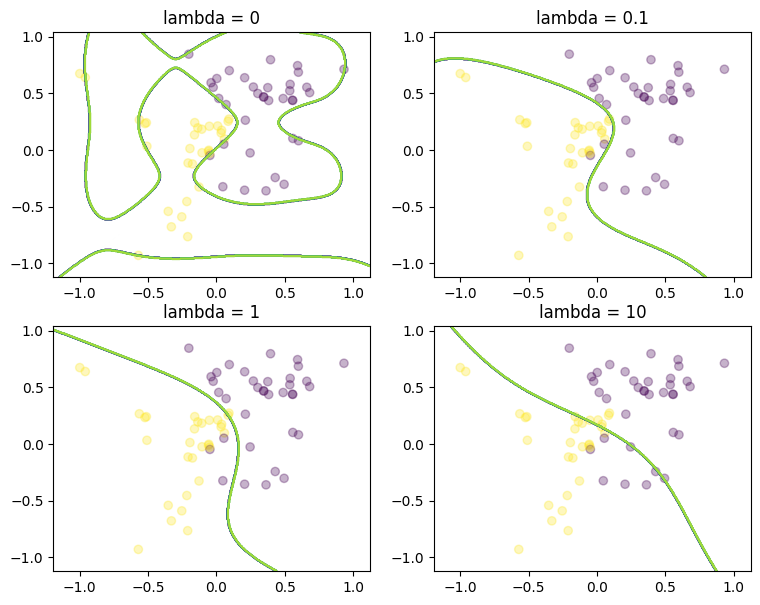

In [22]:
theta_logistic_ipopt = benchmark_lambda(train_df, train_df_lifted, "logistic_regression.mod", "ipopt")

Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.75 sec.
Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.50 sec.
Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.23 sec.
Ipopt 3.12.13: Optimal Solution Found
Solving time: 0.31 sec.


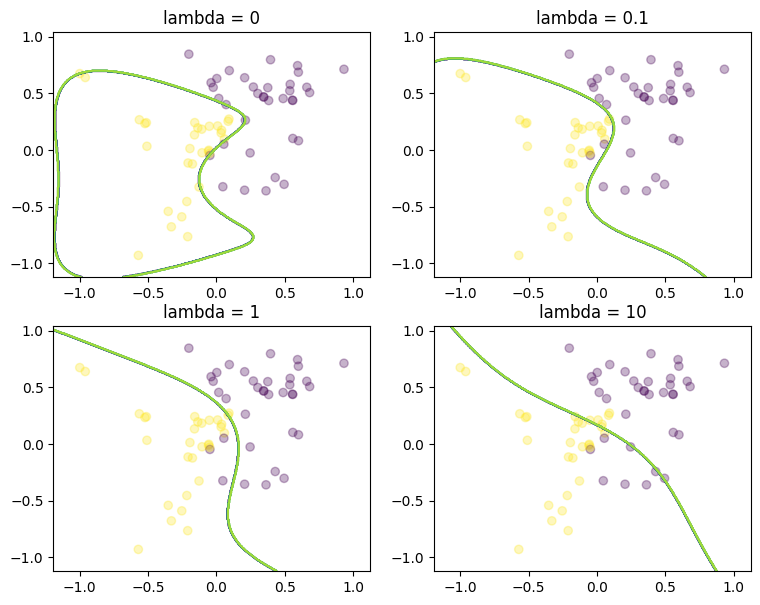

In [23]:
theta_conic_ipopt = benchmark_lambda(train_df, train_df_lifted, "logistic_regression_conic.mod", "ipopt")

MOSEK 10.0.43: optimal, stalling; objective 5.47048488e-06
0 simplex iterations
44 barrier iterations
Solving time: 0.07 sec.
MOSEK 10.0.43: optimal; objective 9.118865748
0 simplex iterations
22 barrier iterations
Solving time: 0.05 sec.
MOSEK 10.0.43: optimal; objective 18.77638933
0 simplex iterations
12 barrier iterations
Solving time: 0.05 sec.
MOSEK 10.0.43: optimal; objective 39.26932934
0 simplex iterations
13 barrier iterations
Solving time: 0.04 sec.


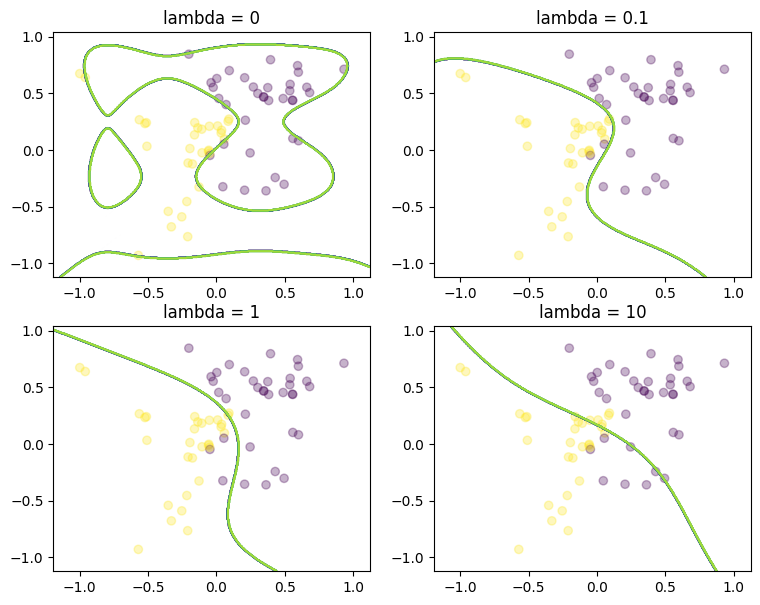

In [24]:
theta_conic_mosek = benchmark_lambda(train_df, train_df_lifted, "logistic_regression_conic.mod", "mosek")

## Evaluate perfornace the optimal $\theta$ for each lambda on the test set

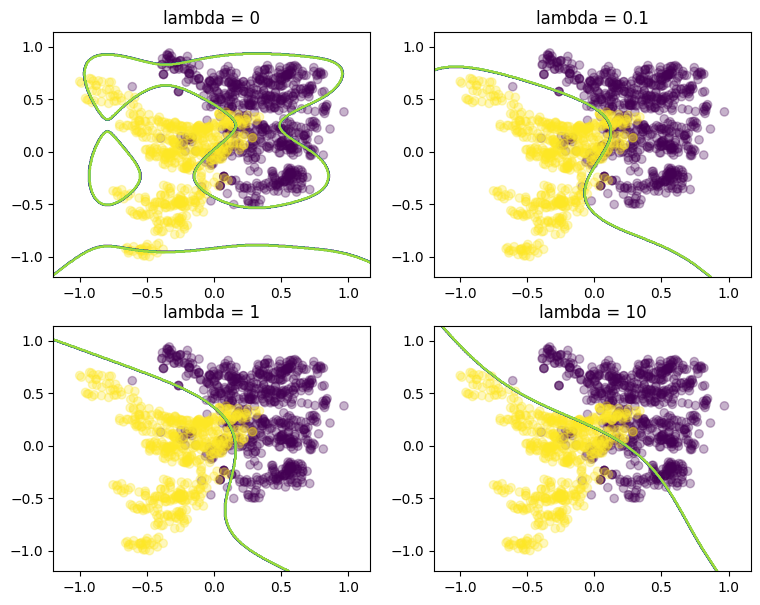

In [25]:
theta = theta_conic_mosek  # using theta from the conic model with MOSEK
fig, axes = plt.subplots(2, 2, figsize=(9, 7))
for lambd, axis in zip([0, 0.1, 1, 10], np.ravel(axes).tolist()):
    plot_regression(test_df, lambd, theta[lambd], axis)
plt.show()

In [26]:
# Check the accuracy for each lambda
for lambd in [0, 0.1, 1, 10]:
    result_df = test_df.copy()
    result_df["pred"] = test_df_lifted.dot(theta[lambd]) >= 0
    accuracy = sum(result_df["Label"] == result_df["pred"])/len(result_df)
    print(f"accuracy with lambda={lambd:5.2f}: {accuracy*100:.2f}%")

accuracy with lambda= 0.00: 81.46%
accuracy with lambda= 0.10: 92.34%
accuracy with lambda= 1.00: 91.42%
accuracy with lambda=10.00: 85.44%


## Discussion

Logistic regression can be modeled as a convex nonlinear optimization problem.

We considered two examples with none, medium and strong regularization (small, medium, large lambda). Without regularization we get obvious overfitting and numerical issues in the solvers.

We considered two mathematical formulations of the problem: general nonlinear and conic. The conic formulation requires a conic programming solver. Both formulations seem hard without regularization: although optimal or close-to-optimal solutions are found quickly, solvers take long time to prove optimality (or quit prematurely).